# Synthetic Terrain & Customization Tutorial

This tutorial showcases the flexibility of the `terrain_navigate` library. We will:
1.  Generate synthetic terrain surfaces.
2.  Visualize them in 3D.
3.  Compare different Cost Functions (`Euclidean` vs `PowerCost`).
4.  Demonstrate how pathfinding behavior changes based on terrain features.

## Setup

In [7]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path
project_root = Path("../../").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.terrain_navigate import AStar, GridEnvironment, EuclideanCost, PowerCost

## 1. Synthetic Terrain Generation
We can create various terrain types using mathematical functions. Here's a helper to generate a "Hilly" terrain with an obstacle.

In [8]:
def generate_terrain(shape=(100, 100), roughness=5.0, obstacle=True):
    x = np.linspace(0, 100, shape[1])
    y = np.linspace(0, 100, shape[0])
    X, Y = np.meshgrid(x, y)
    
    # Base terrain: Sine waves
    Z = np.sin(X/10) * np.cos(Y/10) * roughness + 10
    
    # Add a "Mountain" or Obstacle
    if obstacle:
        Z[40:60, 40:60] += 20.0 
        
    return X, Y, Z

X, Y, Z = generate_terrain()
print(f"Generated terrain with shape {Z.shape}")

Generated terrain with shape (100, 100)


## 2. 3D Visualization
Visualizing the terrain helps understand the challenge for the rover.

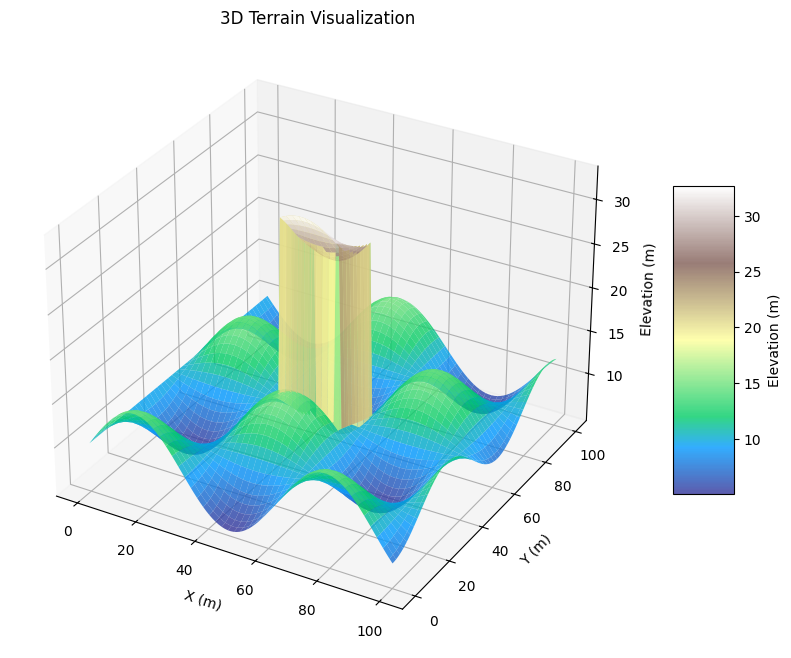

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='terrain', edgecolor='none', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Elevation (m)')
ax.set_title("3D Terrain Visualization")
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Elevation (m)')
plt.show()

## 3. Cost Function Comparison
Here we compare how different cost functions affect the path.

*   **Euclidean Cost**: Shortest distance in 3D space. Ignores slope difficulty (unless it's a vertical wall).
*   **Power Cost**: Penalizes slopes. `Cost = Distance * (1 + alpha * slope^n)`. This makes the rover avoid steep hills even if the path is longer.

In [10]:
# Setup Environment
env = GridEnvironment(
    Z=Z,
    global_x_min=0.0,
    global_x_max=100.0,
    global_y_min=0.0,
    global_y_max=100.0,
    resolution=1.0
)

astar = AStar()

# Define Start and Goal (across the obstacle)
start_node = env.get_nearest_node((10, 10, 0))
goal_node = env.get_nearest_node((90, 90, 0))

# 1. Run Euclidean
print("Planning Euclidean Path...")
path_eucl, cost_eucl = astar.find_path(start_node, goal_node, env, EuclideanCost())

# 2. Run Power Cost (High penalty for slopes)
print("Planning Power Cost Path...")
path_power, cost_power = astar.find_path(start_node, goal_node, env, PowerCost(n=2.0, alpha=20.0))

Planning Euclidean Path...
Planning Power Cost Path...


## 4. Visualizing the Difference
We plot both paths on the 2D heightmap. Notice how the **Power Cost** path (Blue) goes *around* the steep obstacle, while the **Euclidean** path (Red) goes straight over it.

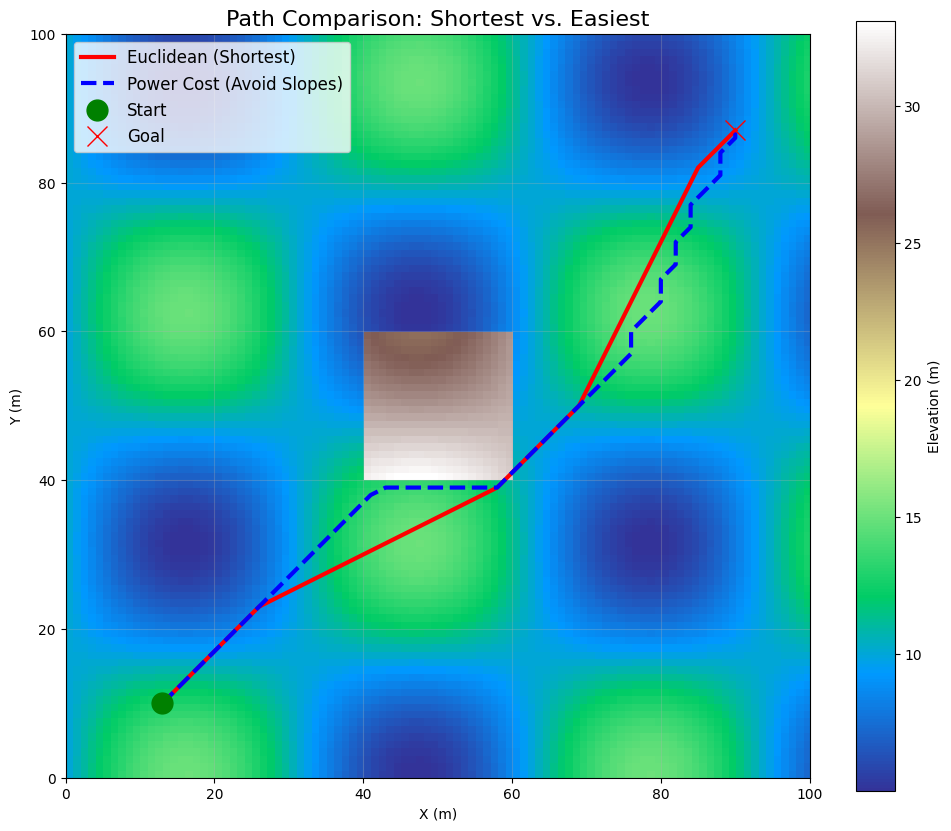

In [11]:
plt.figure(figsize=(12, 10))
plt.imshow(Z, cmap='terrain', origin='lower', extent=[0, 100, 0, 100])
plt.colorbar(label='Elevation (m)')

if path_eucl is not None:
    p_e = np.array(path_eucl)
    plt.plot(p_e[:, 0], p_e[:, 1], 'r-', linewidth=3, label='Euclidean (Shortest)')

if path_power is not None:
    p_p = np.array(path_power)
    plt.plot(p_p[:, 0], p_p[:, 1], 'b--', linewidth=3, label='Power Cost (Avoid Slopes)')

plt.plot(start_node[0], start_node[1], 'go', markersize=15, label='Start')
plt.plot(goal_node[0], goal_node[1], 'rx', markersize=15, label='Goal')

plt.legend(fontsize=12)
plt.title("Path Comparison: Shortest vs. Easiest", fontsize=16)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(True, alpha=0.3)
plt.show()

## 5. Testing Custom Cost Functions
We will now test the four custom cost functions derived from the technical design document.

In [12]:
# Import new cost functions
from src.terrain_navigate.costs import ApproachOneCost, ApproachTwoCost, ApproachThreeCost, ApproachFourCost

In [ ]:
# Run A* with new cost functions
print("Planning Approach 1 Path...")
path_app1, cost_app1 = astar.find_path(start_node, goal_node, env, ApproachOneCost(n=2.0))

print("Planning Approach 2 Path...")
path_app2, cost_app2 = astar.find_path(start_node, goal_node, env, ApproachTwoCost(n1=2.0, n2=2.0))

print("Planning Approach 3 Path...")
path_app3, cost_app3 = astar.find_path(start_node, goal_node, env, ApproachThreeCost(n1=2.0, n2=2.0, alpha1=1.0, beta1=0.0, alpha2=1.0, beta2=0.0))

print("Planning Approach 4 Path...")
path_app4, cost_app4 = astar.find_path(start_node, goal_node, env, ApproachFourCost(n1=1.0, n2=1.0, alpha=1.0))

Planning Approach 1 Path...
Planning Approach 2 Path...
Planning Approach 3 Path...


In [ ]:
# Visualize all paths
plt.figure(figsize=(14, 12))
plt.imshow(Z, cmap='terrain', origin='lower', extent=[0, 100, 0, 100])
plt.colorbar(label='Elevation (m)')

if path_eucl is not None:
    p = np.array(path_eucl)
    plt.plot(p[:, 0], p[:, 1], 'r-', linewidth=2, label='Euclidean', alpha=0.7)

if path_power is not None:
    p = np.array(path_power)
    plt.plot(p[:, 0], p[:, 1], 'b--', linewidth=2, label='Power Cost', alpha=0.7)

if path_app1 is not None:
    p = np.array(path_app1)
    plt.plot(p[:, 0], p[:, 1], 'm-.', linewidth=2, label='Approach 1')

if path_app2 is not None:
    p = np.array(path_app2)
    plt.plot(p[:, 0], p[:, 1], 'c:', linewidth=2, label='Approach 2')

if path_app3 is not None:
    p = np.array(path_app3)
    plt.plot(p[:, 0], p[:, 1], 'y-', linewidth=2, label='Approach 3')

if path_app4 is not None:
    p = np.array(path_app4)
    plt.plot(p[:, 0], p[:, 1], 'k--', linewidth=2, label='Approach 4')

plt.plot(start_node[0], start_node[1], 'go', markersize=15, label='Start')
plt.plot(goal_node[0], goal_node[1], 'rx', markersize=15, label='Goal')

plt.legend(fontsize=10, loc='upper left')
plt.title("Comparison of All Cost Functions", fontsize=16)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(True, alpha=0.3)
plt.show()